# Interpretable Machine Learning
## Exercise Sheet: 10
## This exercise sheet covers chapters 10.3 and 10.4 from the IML book by Christoph Molnar
Kristin Blesch (blesch@leibniz-bips.de)<br>
Niklas Koenen (koenen@leibniz-bips.de)
<hr style="border:1.5px solid gray"> </hr>

# 1) Detecting Concepts

## a) Concept Activation Vector (CAV)

How do you determine a Concept Activation Vector (CAV) for a given concept $C$ and how can it be interpreted? If possible, explain the CAV with an example in the plane $\mathbb{R}^2$.

**Solution:**

A concept activation vector (CAV) $v_l^C$ is a numerical representation that generalizes a concept $C$ in the activation space of a neural network layer $l$. It is calculated by the following steps:

  1. Prepare two datasets: a concept dataset $\mathcal{D}_C$ that represents the given concept $C$ and random dataset $\mathcal{D}_\text{rand}$ that consists of arbitrary data
  2. Get the activation maps for the chosen layer $l$ for both datasets by forward propagating, i.e. let $\hat{f}_l$ a function that maps the model input to the activation map of layer $l$ then create $\hat{\mathcal{D}}_C = \hat{f}_l\left(\mathcal{D}_C\right)$ and $\hat{\mathcal{D}}_\text{rand} = \hat{f}_l\left(\mathcal{D}_\text{rand}\right)$
  3. Train a binary classifier (SVM or logistic regression) which separates the activation maps $\hat{\mathcal{D}}_C$ and $\hat{\mathcal{D}}_\text{rand}$
  4. The coefficient vector of this trained binary classifier is then the CAV $v_l^C$

Let's consider a simple case in the plane $\mathbb{R}^2$: Let $\hat{\mathcal{D}}_C$ sampled by $\mathcal{N}\left(\begin{pmatrix} 2 \\ 2 \end{pmatrix}, \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}\right)$ and $\hat{\mathcal{D}}_\text{rand}$ by $\mathcal{N}\left(\begin{pmatrix} -2 \\ -2 \end{pmatrix}, \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}\right)$. The fitted logistic regression model has the following form: 
$$
\text{model}(x) = \text{logistic}\left( 1 \cdot x_1 + 1 \cdot x_2 \right).
$$
Thus, the CAV $v_l^C$ is given by $v_l^C=\begin{pmatrix} 1 \\ 1 \end{pmatrix}$ (red arrow in figure below). As you can see in the figure below, the CAV points exactly in the direction that most rapidly increases the probability of the concept $C$.
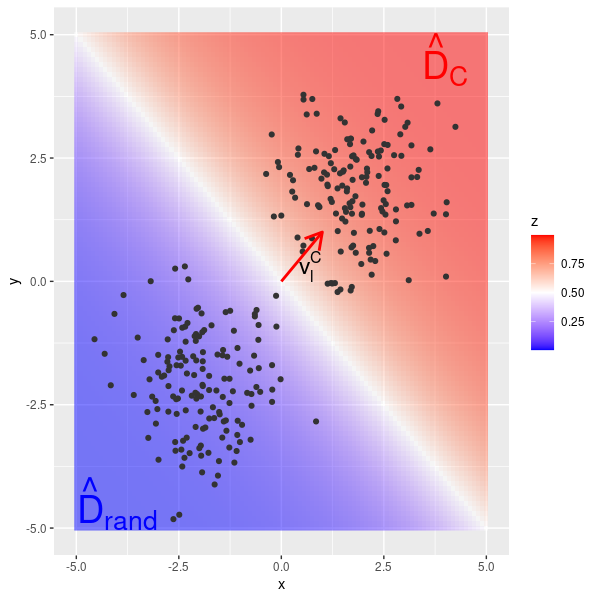

## b) Testing with CAVs (TCAV)

Explain the TCAV approach. What does the calculated TCAV score mean and how can we check whether it is meaningful for the given concept or not?

**Solution:**

We can measure the “conceptual sensitivity” of an input $x$ by calculating the directional derivative of the prediction in the direction of the unit CAV (where $h_{l,k}$ maps the activation map to the logit output of the class $k$):
$$S_{C,k,l}(x)=\nabla h_{l,k}(\hat{f}_l(x))\cdot v_l^C$$
Since the gradient $\nabla h_{l,k}$ points to the direction that maximizes the output the most rapidly, conceptual sensitivity $S_{C,k,l}$, intuitively, indicates whether $v_l^C$ points to a similar direction that maximizes $h_{l,k}$. Thus, $S_{C,k,l}(x) > 0$ can be interpreted as concept $C$ encouraging the model to classify $x$ into class $k$. Or in other words:

   - $S_{C,k,l}(x) > 0$: Acute angle between CAV and gradient (similar directions)
   - $S_{C,k,l}(x) < 0$: Obtuse angle between CAV and gradient (different directions)
   
Testing with CAVs (TACV): Calculate the ratio of inputs with positive conceptual sensitivities to the number of inputs for a class $k$ ($X_k$ is a dataset of images corresponding to class $k$):
$$
TCAV_{C,k,l}=\frac{|{x\in X_k:S_{C,k,l}(x)>0}|}{|X_k|}
$$
The TCAV value is a percentage that indicates on what percentage of the data on a specific concept $C$, the model also recognized that concept (defined by similar directions between gradient and CAV). Consider the following example from the book:
> We collect data that are labeled as “zebra” and calculate conceptual sensitivity for each input image. Then the TCAV score of the concept “striped” with predicting class “zebra” is the number of “zebra” images that have positive conceptual sensitivities divided by the total number of the “zebra” images. In other words, a  TCAV value equal to 0.8 indicates that 80% of predictions for “zebra” class are positively influenced by the concept of “striped”.

If datasets used to train the CAV are bad, the explanation can be misleading and useless. And thus, we perform a simple statistical significance test to help TCAV become more reliable.

   1. Collect $N$ random datasets, where it is recommended that $N$ is at least $10$
   2. Fix the concept dataset and calculate TCAV score using each of $N$ random datasets
   3. Apply a two-sided t-test to $N$ TCAV scores against other $N$ TCAV scores generated by a random CAV. A random CAV can be obtained by choosing a random dataset as the concept dataset.
    
It is also suggested to apply a multiple testing correction method here if you have multiple hypotheses, e.g. Bonferroni correction and here the number of hypotheses is equal to the number of concepts you are testing

# 2) Adversarial Examples

## a) Methods

In chapter 10.4, 6 possibilities are presented to generate adversarial examples. List these and briefly explain how they work and differ.

**Solution:**

#### 1. Adding small error (Szegedy et al., 2013)

- Generate an error $r$ as small as possible that (added to the input image) predicts a different class $l$.
- Gradient-based optimization approach: $$x^\prime = \underset{r}{\arg \min}\ \underbrace{loss(\hat{f}(x+r),l)}_{\text{difference between prediction of the} \\ \text{adversarial example } x + r \text{ and the desired class } l} + c \overbrace{\cdot|r|}^{\text{distance between adversarial} \\ \text{example and original image}}$$
- Allows the selection of the incorrectly detected class (in htis case $l$)
- Almost identical to the loss function to generate counterfactual explanations  
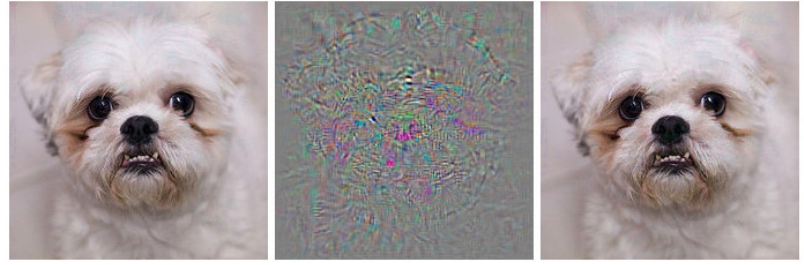
    
#### 2. Fast gradient sign method (Goodfellow et al., 2014)

- Manipulate the input image $x$ by adding a small error $\epsilon$ to each pixel in the direction of the gradient of the models loss w.r.t. the input ($y$ is the true label): $$x^\prime=x+\epsilon\cdot{}sign\left(\nabla_x loss(\hat{f}(x, y)\right)$$
- Only one gradient step is applied with respect to the input $x$, but with the same step size $\epsilon$ for all input pixels and in the direction that maximizes the loss function instead of minimizing it.
- All pixels are modified
- By having the same step size for all input pixels, pixels can be moved outside of the data distribution, which could cause unrealistic adversarial examples.
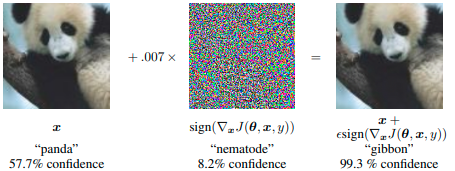
    
#### 3. 1-pixel attacks (Su et al., 2019)
    
- Only a single input pixel may change
- An iterative approach based on differential evolution:
    1. Create a start population (candidate solution) represented by a vector of five elements: the x- and y-coordinates and the red, green and blue (RGB) values, e.g. $400$ random positions and rgb values
    2. Now iteratively repeat:
        1. For each candidate $x_i$ in the canditate solution:
            1. For each of the five elements $k$ in the vector $x_i$:
                1. Get three different random candidates $x_{r1}, x_{r2}, x_{r3}$ from the current generation $g$
                2. Create a new child candidate using the following formula: $$\tilde{x}_i^k = x_{r1}^k + F \cdot \left( x_{r2}^k - x_{r3}^k\right)$$ where $F$ is a scaling parameter (set to $0.5$).  Each new child candidate solution is in turn a pixel with the five attributes for location and color and each of those attributes is a mixture of three random parent pixels.
        2. Calculate the model output of the chosen class $l$ for the input image changed by the parent candidate $x_i$ (denoted as $y_i$) and for the input image changed by the new child candidate $\tilde{x}_i$ (denoted as $\tilde{y}_i$)
        3. If the new candidate $\tilde{x}_i$ has a higher probability for the adversarial class $l$ (i.e. $\tilde{y}_i > y_i$), the parent candidate $x_i$ is replaced by the new one.
        4. Stop if one of the candidate solutions is an adversarial example, meaning it is classified as an incorrect class, or if the number of maximum iterations specified by the user is reached.
- You can select the adversarial class or set it arbitrarily
- Requires a lot of computing power

#### 4. Adversarial patch (Brown et al., 2017)

- A printable label that can be stuck next to objects to make them look like toasters for an image classifier.
- In this case the input image is not only slightly changed, but a whole part of the image is replaced with a patch that can take on any shape
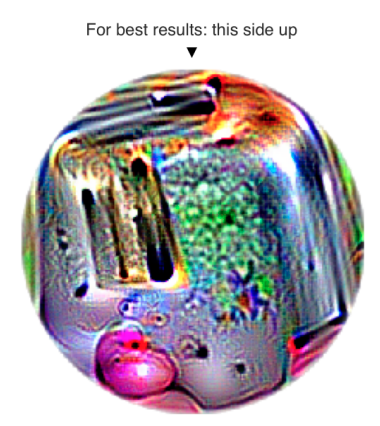

#### 5. Robust adversarial examples (Athalye et al., 2017)

- They created a 3D-printed a turtle that was designed to look like a rifle to a deep neural network from almost all possible angles.
- They propose the Expectation Over Transformation (EOT) algorithm, which is a method for generating adversarial examples that even work when the image is transformed. The main idea behind EOT is to optimize adversarial examples across many possible transformations.
- We try to find an adversarial example $x'$ that maximizes the probability for the selected class $y_t$ (e.g. "rifle") across the distributionnof possible transformations $T$: $$\arg\max_{x^\prime}\mathbb{E}_{t\sim{}T}[log{}P(y_t|t(x^\prime))]\quad \text{with constraint}\quad \mathbb{E}_{t\sim{}T}[d(t(x^\prime),t(x))]<\epsilon$$
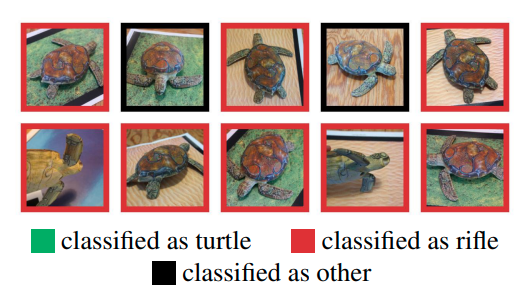

#### 6. Black box attack (Papernot et al., 2017)

- This approach creates adversarial examples without internal model information and wihtout access to the training data.
- This type of (almost) zero-knowledge attack is called black box attack.
- Basically, a surrogate model is iteratively learned on domain-like data as the trainings data in order to approximate the decision boundaries of the black box model.
- The method even works if the black box model to be deceived is not a neural network. This includes machine learning models without gradients such as a decision trees.

## b) The Cybersecurity Perspective

Explain the three golden rules in cybersecurity.

**Solution:**

#### 1. Know your adversary

Different applications have different adversaries. Therefore, knowing your adversaries means knowing their goals. Only if you know the goals of an attacker, you can prepare or defend yourself accordingly.

#### 2. Be proactive

Being proactive means actively testing and identifying weak points of the system. You are proactive when you actively try to deceive the model with adversarial examples and then defend against them. Using interpretation methods to understand which features are important and how features affect the prediction is also a proactive step in understanding the weaknesses of a machine learning model.

#### 3. Protect yourself
There are several aproaches:

- Iterative retraining of the classifier with adversarial examples (also called adersarial training)
- Based on game theory: Learning invariant transformations of the features or robust optimization (regularization)
- Ensemble: Use multiple classifiers instead of just one and use the average prediction